In [1]:
%autosave 0
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from datetime import date, timedelta

from source_code.SqlCo import Sqldd

Autosave disabled
Local Sec Env loaded


# Init_var

In [23]:
## Init global var/ simulate input from app in prod (not for periode)
country = 'France'
subject = 'total_deaths'
periode = 3
test_size = 3

# Input 

In [24]:
tip = Sqldd()
cnx, cursor = tip.get_bdd_co()
df = pd.read_sql(f"SELECT * FROM cov_baseline;", con=cnx)

In [25]:
df.columns

Index(['id', 'iso_code', 'continent', 'location', 'date', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [26]:
df = df[df['location'].isin([f"{country}"])] 
df = df.reset_index()
data_see = df[[f"{subject}"]]

In [27]:
def massBalance():
    thisPlot = px.line(x=df["date"], y=data_see)
    thisPlot.update_layout(title=f"{country}",
                           xaxis_title="Mois",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [28]:
massBalance()

In [29]:
rolling_mean = data_see.rolling(window = periode).mean()
rolling_std = data_see.rolling(window = periode).std()

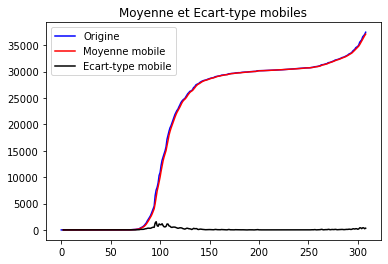

In [30]:
plt.plot(data_see, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

# Train Test Split

In [31]:
data_see_np = data_see.values
len_data_see = len(data_see_np)
train_data_see = data_see_np[:len_data_see-test_size] 
test_data_see = data_see_np[len_data_see-test_size:]

# Stats Models

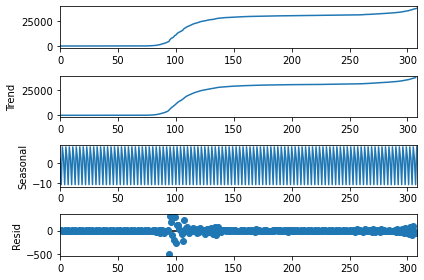

In [32]:
temp_df =  df[[f"{subject}"]].fillna(0)
result = seasonal_decompose(temp_df, model='additive', period=periode) ## cumulative
result.plot()
plt.show()

In [33]:
seasonal = result.seasonal
trend = result.trend

residual = df[f"{subject}"] - seasonal - trend
residual = residual.fillna(0)

In [34]:
ADF_result = adfuller(df[f"{subject}"].fillna(0))
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.0560694568463507
p-value: 0.732269366177484


In [35]:
ADF_result_residual = adfuller(residual)
print(f'ADF Statistic: {ADF_result_residual[0]}')
print(f'p-value: {ADF_result_residual[1]}')

ADF Statistic: -4.980470612401727
p-value: 2.4255388250055695e-05


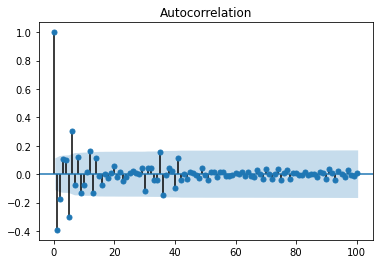

In [36]:
plot_acf(residual, lags=100)
plt.show()

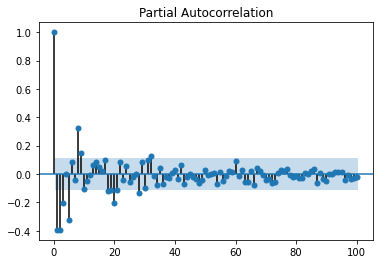

In [37]:
plot_pacf(residual, lags=100);

# Forecast

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  306
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1883.611
Date:                Tue, 03 Nov 2020   AIC                           3789.223
Time:                        15:47:27   BIC                           3830.146
Sample:                             0   HQIC                          3805.591
                                - 306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3665      0.067      5.456      0.000       0.235       0.498
ar.L2          0.0119      0.046      0.261      0.794      -0.077       0.101
ar.L3          0.3247      0.047      6.943      0.0

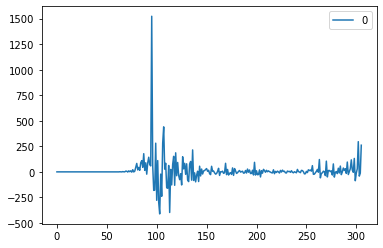

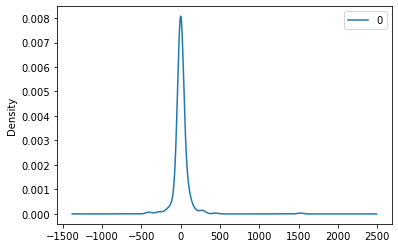

                 0
count   306.000000
mean      9.973677
std     115.204770
min    -411.657311
25%      -9.388137
50%       0.000000
75%      14.777270
max    1523.546493


In [49]:
def arrimm(x, silence_mod=False):
    # fit model
    model = ARIMA(x, order=(10,1,0))
    model_fit = model.fit()
    
    if not silence_mod:
        print(model_fit.summary())
        # plot residual errors
        residuals = pd.DataFrame(model_fit.resid)
        residuals.plot()
        plt.show()
        residuals.plot(kind='kde')
        plt.show()
        print(residuals.describe())
    return model_fit
    
model_arrima = arrimm(train_data_see)

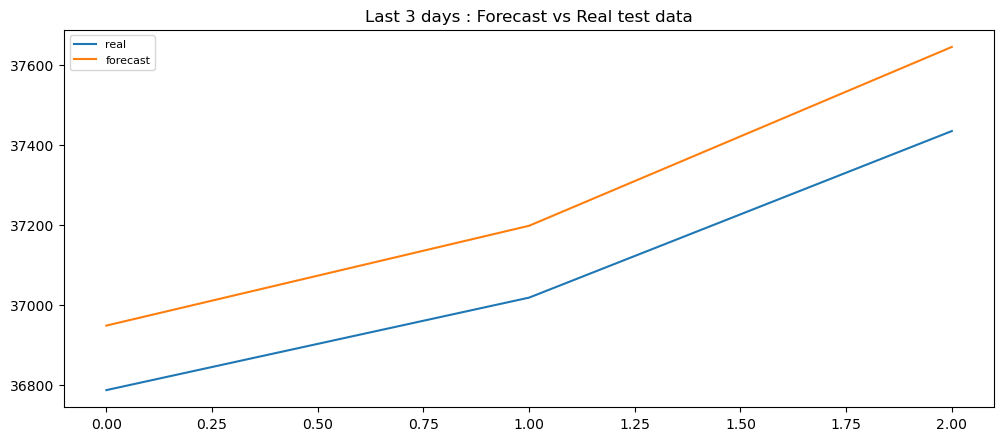

In [50]:
# Forecast
fc = model_arrima.forecast(test_size, alpha=0.05)  # 95% conf

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train_data_see, label='training')
plt.plot(test_data_see, label='real')
plt.plot(fc, label='forecast')
plt.title(f'Last {test_size} days : Forecast vs Real test data')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
RMSE = np.sqrt(MSE(fc,test_data_see))
print("RMSE : ", RMSE.round(4))

score = MAE(fc,test_data_see)
print("MAE : ", round(score,4))

RMSE :  184.6706
MAE :  183.5646


In [41]:
model_arrima_full = arrimm(data_see_np,silence_mod=True)

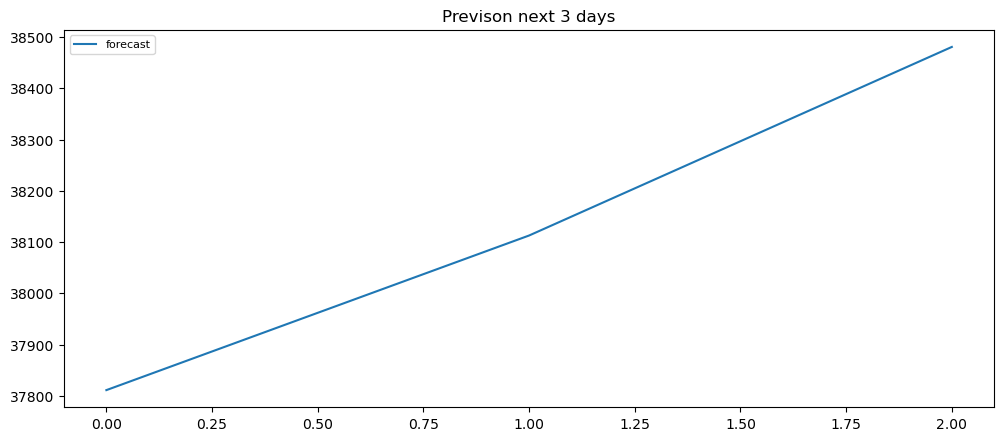

[37811.3857287  38112.84976995 38480.51681403]


In [42]:
fc_full = model_arrima_full.forecast(test_size, alpha=0.05)  # 95% conf
# Plot

plt.figure(figsize=(12,5), dpi=100)
plt.plot(fc_full, label='forecast')
plt.title(f'Previson next {test_size} days')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(fc_full)

# LSTM

In [20]:
data_see_np = df[[f"{subject}"]].values

In [21]:
data_see_np.shape

(287, 1)

In [22]:
def modSplit(periode, df_train):
    
    hisShape_train = df_train.shape[0]
    
    sc = StandardScaler()
    df_train = sc.fit_transform(df_train)

    #### Train prep ####
    x_train = []
    y_train = []

    for i in range(periode,hisShape_train):
        x_train.append(df_train[(i-periode):i,0]) 
        y_train.append(df_train[i,0])
        
    x_train = np.array(x_train)
    y_train = np.array(y_train)
     
    return sc, x_train, y_train, 

In [23]:
sc, x_train, y_train,  = modSplit(periode, data_see_np)

In [24]:
input_dim = 1
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],input_dim)
x_train.shape, y_train.shape

((284, 3, 1), (284,))

In [25]:
def recurrent_model(neurons=50):
    model = Sequential()
    
    model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.1))
    
#     model.add(LSTM(25, return_sequences=True))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(12, return_sequences=True))
#     model.add(Dropout(0.2))
    
    model.add(LSTM(6, return_sequences=False))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))
    model.compile(optimizer="Adam",loss="mean_squared_error")
 
    return model

In [26]:
model = recurrent_model(neurons=40)
history = model.fit(x_train, y_train, epochs=100, batch_size=12)

Epoch 1/100
24/24 [==============================] - 0s 10ms/step - loss: 0.8620
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.5339
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2182
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0746
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0338
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0293
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0244
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0255
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 11/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0336
Epoch 12/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 13/100
24/24 [=========

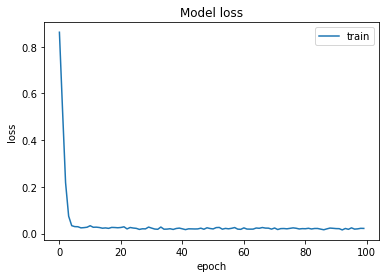

In [27]:
def hist_foll(metrics):
    plt.plot(history.history[f'{metrics}'])
    plt.grid = True
    plt.title(f'Model {metrics}')
    plt.ylabel(f'{metrics}')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plt.show

hist_foll('loss') 

In [28]:
def BestParams():
    estimators = []
#     estimators.append(('pf', PolynomialFeatures(interaction_only=True,include_bias=False)))
    estimators.append(('nn', KerasRegressor(build_fn=recurrent_model, epochs=100, batch_size=32, neurons=20, verbose=0)))
    
    nn_pipe = Pipeline(estimators)
    
    print(nn_pipe.get_params().keys())
    
    nn_param_grid = {'nn__batch_size':[12,24,32],'nn__neurons':[20,30,40]} ##'nn__neurons':[50,100,200]
    
    gs_nn = GridSearchCV(nn_pipe, nn_param_grid,verbose=0, cv=3)
    print('Ok')
    gs_nn.fit(x_train, y_train)
    
    return gs_nn.best_params_

In [29]:
lookForOptimiz = False
if lookForOptimiz : 
    best = BestParams()
    print(best)

In [30]:
pred = model.predict(x_train)
pred = sc.inverse_transform(pred)

In [31]:
base_y = sc.inverse_transform(y_train)
RMSE = np.sqrt(MSE(pred,base_y))
print("RMSE : ",RMSE.round(4))

score = MAE(pred,base_y)
print("MAE : ", round(score,4))

RMSE :  454.0315
MAE :  334.9876
